In [1]:
from comut import comut
from comut import fileparsers
import palettable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Linux-5.4.0-59-generic-x86_64-with-debian-buster-sid
Python 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
NumPy 1.19.5
SciPy 1.6.0
Scikit-Learn 0.24.1


In [4]:
"""
Global functions used in this notebook
"""
def make_list(df,string):
    lists   =list(df[string].drop_duplicates())
    return lists

def annon(df1,string,df2):
    df_annon     =pd.merge(df1,df2,on=string)
    return df_annon

def add_column(df,lists,string,newcolname):
    df[newcolname]  = np.where(df['gene_sym'].isin(lists),'Yes','No')
    return df

def readfile(path,filename):
    df = pd.read_csv(path+filename,header=0,sep='\t',skipinitialspace=True)
    return df

def annotate_features(df,cancer_driver,drugtarget,triplex,promo_methy,SNPS):
    """
    Feature annotation, adding column to de lncRNAs datafrme based on the feature information
    """
    df =add_column(df,cancer_driver,"gene_sym","cancer_driver")
    df =add_column(df,drugtarget,"gene_sym","drug_target")
    df =add_column(df,triplex,"gene_sym","triplex")
    df =add_column(df,promo_methy,"gene_sym","promoter_methylated")
    df =add_column(df,SNPS,"gene_sym","SNPS")
    return df  

def rename_cols(df,oldname,newname):
    df.rename(columns={oldname:newname},inplace=True)
    return df

def outers_join(df1,df2,string):
    df_new = pd.merge(df1, df2, on=string,how="outer")
    return df_new

def label_paths (row):
    if row['Pathway'] == "unknown":
        return 0
    else:
        return 1
    
def percentage_calc(count_ofyes,countofno,question):
    """
    Percentage calculator for the number of pathways
    """
    pct_of_no_sub = countofno/(countofno+count_ofyes)
    pct_of_sub    = (count_ofyes)/(countofno+count_ofyes)
    return(print("percentage of lncRNAs without" + question, pct_of_no_sub*100),print("percentage of lncRNAs with"+question, pct_of_sub*100))


In [3]:
def data_preparation(common_de,snps,lncRNAs_ref,common_de_ezh2_h2k27,clc,meth):
    """
    Make the dataframe for the logic regression analysis with all avaliable meta information for the pan cancer common 
    De lncRNAs file
    """
    SNPS_ann       = pd.merge(lncRNAs_ref[["gene_id","gene_sym"]],snps_all[["gene_id","p-Value"]],on="gene_id")
    SNPS_ann       = rename_cols(SNPS_ann,"p-Value","risk_alelle_freq")
    SNPS_ann.drop_duplicates(inplace=True)
    SNPS_ann_de    = pd.merge(common_de['gene_sym'],SNPS_ann[["risk_alelle_freq","gene_sym"]],on='gene_sym')
    SNPS_ann_de['risk_alelle_freq'] = pd.to_numeric(SNPS_ann_de['risk_alelle_freq'], errors='coerce')
    SNPS_ann_de.fillna(0, inplace=True)
    SNPS_ann_de    = SNPS_ann_de.sort_values(by='risk_alelle_freq', ascending=False)
    SNPS_ann_de.drop_duplicates(subset='gene_sym', keep="first",inplace=True)
    chrom_de_ezh2  = common_de_ezh2_h2k27.query('chromatin=="EZH2"')
    chrom_de_H3K27 = common_de_ezh2_h2k27.query('chromatin=="H3K27"')
    chrom_de_H3K27 = chrom_de_H3K27[["gene_sym","sample","logFC_chromatin"]]
    chrom_de_ezh2  = chrom_de_ezh2[["gene_sym","sample","logFC_chromatin"]]
    clc_de         = pd.merge(common_de['gene_sym'],clc,on='gene_sym')
    brca_meth_de   = pd.merge(common_de[['gene_sym','sample']],Methylated[["gene_sym","Meth_Mean","sample"]],on=['gene_sym','sample'])
    brca_new       = pd.merge(common_de, SNPS_ann_de, on='gene_sym',how="outer")
    brca_new       = outers_join(brca_new,chrom_de_ezh2[["gene_sym","logFC_chromatin"]],"gene_sym")
    brca_new       = outers_join(brca_new,chrom_de_H3K27[["gene_sym","logFC_chromatin"]],"gene_sym")
    brca_new = rename_cols(brca_new,"logFC_chromatin_x","EZH2")
    brca_new = rename_cols(brca_new,"logFC_chromatin_y","H3K27")
    brca_new = outers_join(brca_new,clc_de,"gene_sym")
    brca_new = pd.merge(brca_new, brca_meth_de, on=['gene_sym','sample'],how="outer")
    brca_new.fillna('unknown', inplace=True)
    brca_new.drop(['SNPS'],axis=1,inplace=True)
    return brca_new

In [4]:
refs        = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/Tcga_R/GDCdata/TCGA-BRCA/harmonized/Transcriptome_Profiling/Gene_Expression_Quantification/r_data/reference/Homo_sapiens.GRCh38.97.chr.txt'
ref         = pd.read_csv(refs, sep="\t", header=0,skipinitialspace=True)
lncRNAs_ref = ref.query('biotype == "lncRNA"')
PC_ref      = ref.query('biotype == "protein_coding"')

In [5]:
path                  = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/filtered_results/'
chrompath             = "/home/alva/Documents/lncRNAs_project_2020/MEG3/"
depath                = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/'
methy                 = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/'
cancer_lncRNAs_census = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/autoencoder_lncRNAs/data/'
SNPS                  = "/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/lncRNAs_TCGA/"
pathmeg3              = "/home/alva/Documents/lncRNAs_project_2020/MEG3/"
de                    = "/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/filtered_results/"

In [7]:
common_de           = readfile(path,"commonDE_5cancermetainformation")
pathways            = readfile(path,"cis_onco_pathways_ann_cols")
triplex             = readfile(depath,"tripleFPP_triplex_genecode")
Methylated          = readfile(methy,'methylated_lncRNAs')
clc                 = readfile(cancer_lncRNAs_census,"lncRNA_CLC")
snps_all            = readfile(SNPS,"SNPs_loci_lncRNAs_cancertypes")
de_fc               = readfile(de,"lncRNAs_acrossatleast5cancer")

In [8]:
clc = clc[["NAME AS PUBLISHED","Oncogene (o) or Tumour Supp(t)"]]
clc = rename_cols(clc,"NAME AS PUBLISHED","gene_sym")
clc = rename_cols(clc,"Oncogene (o) or Tumour Supp(t)","types")
Methylated           = rename_cols(Methylated,"Gene","gene_sym")
common_de["sample"]  = common_de["filename"].apply(lambda x:x.split("-")[1])
common_de.drop('filename',axis=1,inplace=True)
de_fc["sample"]      = de_fc["filename"].apply(lambda x:x.split("-")[1])
de_fc                = rename_cols(de_fc,"external_gene_name","gene_sym")
de_fc.drop('filename',axis=1,inplace=True)

In [9]:
EZH2  = readfile(pathmeg3,"EZH2_enriched_lncRNAs")
EZH2  = rename_cols(EZH2,"GeneSymbol","gene_sym")
H3K27 = readfile(pathmeg3,"H3k27_enriched_lncRNAs")
H3K27 = rename_cols(H3K27,"GeneSymbol","gene_sym")

In [10]:
common_de_EZH2       = pd.merge(de_fc[["gene_sym","logFC","sample"]],EZH2[["gene_sym","logFC"]],on="gene_sym",suffixes=('_de', '_chromatin'))
common_de_EZH2["chromatin"] = "EZH2"
common_de_H3K27      = pd.merge(de_fc[["gene_sym","logFC","sample"]],H3K27[["gene_sym","logFC"]],on="gene_sym",suffixes=('_de', '_chromatin'))
common_de_H3K27["chromatin"] = "H3K27"
common_de_ezh2_h2k27 = pd.concat([common_de_H3K27,common_de_EZH2])

In [11]:
common_de_ezh2_h2k27

,gene_sym,logFC_de,sample,logFC_chromatin,chromatin
0,AC131097.3,-1.271944,KIRP,4.165595,H3K27
1,AC131097.3,-0.948757,LUAD,4.165595,H3K27
2,AC131097.3,-1.363466,LUSC,4.165595,H3K27
3,AC131097.3,-0.839736,PRAD,4.165595,H3K27
4,AC131097.3,-0.812610,THCA,4.165595,H3K27
...,...,...,...,...,...
209,ZEB1-AS1,1.092297,ESCA,5.121238,EZH2
210,ZEB1-AS1,-1.052096,KICH,5.121238,EZH2
211,ZEB1-AS1,1.083651,KIRP,5.121238,EZH2
212,ZEB1-AS1,0.705494,LIHC,5.121238,EZH2


In [12]:
common_de_melt      = pd.melt(common_de,id_vars=['gene_sym','sample'],var_name='category',value_name='value')
common_de_data      = common_de_melt[["gene_sym","sample"]]
common_de_data      = pd.merge(common_de_data,pathways,on="gene_sym")
common_de_data

,gene_sym,sample,Pathway
0,AC004846.1,BRCA,NOTCH
1,AC004846.1,COAD,NOTCH
2,AC004846.1,KICH,NOTCH
3,AC004846.1,KIRC,NOTCH
4,AC004846.1,KIRP,NOTCH
...,...,...,...
4202,WNT5A-AS1,KICH,WNT
4203,WNT5A-AS1,KIRC,WNT
4204,WNT5A-AS1,KIRP,WNT
4205,WNT5A-AS1,LUSC,WNT


In [13]:
common_de_new  = data_preparation(common_de,snps_all,lncRNAs_ref,common_de_ezh2_h2k27,clc,Methylated)
common_de_new  = pd.merge(common_de_new,de_fc[["logFC","sample","gene_sym"]],on=['gene_sym',"sample"])
common_de_new                = pd.merge(common_de_new, common_de_data[["gene_sym","Pathway","sample"]], on=['gene_sym','sample'],how="outer")
common_de_new.fillna('unknown', inplace=True)
common_de_new["pathway_y"]   = common_de_new.apply(lambda row: label_paths(row), axis=1)
common_de_new                = common_de_new.replace("No","unknown")
num_cols                     = ['EZH2', 'H3K27','logFC','Meth_Mean','risk_alelle_freq','pathway_y']
common_de_new[num_cols]      = common_de_new[num_cols].apply(pd.to_numeric, errors='coerce')

Data exploration

In [28]:
common_de_new[["gene_sym","Pathway"]].drop_duplicates()

,gene_sym,Pathway
0,A1BG-AS1,unknown
9,A2M-AS1,unknown
18,AADACL2-AS1,unknown
23,ABALON,unknown
29,ABCA9-AS1,unknown
...,...,...
42884,ZNF793-AS1,unknown
42891,ZNF8-ERVK3-1,unknown
42896,ZRANB2-AS1,unknown
42902,ZRANB2-AS2,unknown


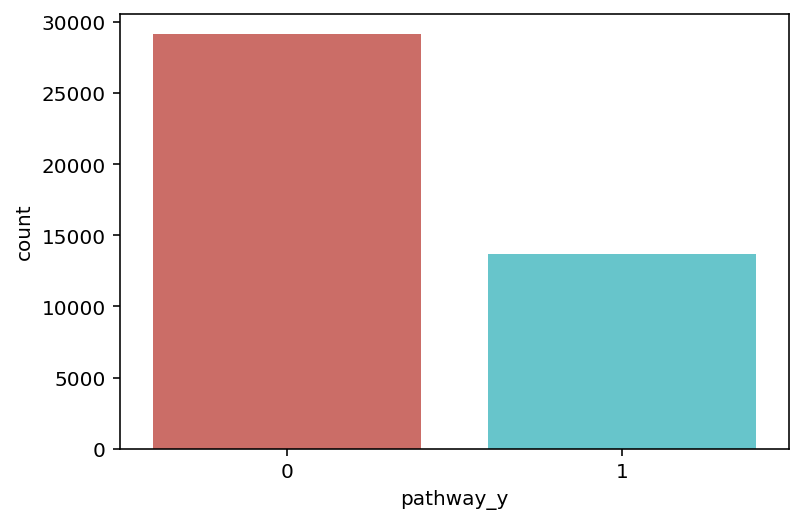

<Figure size 432x288 with 0 Axes>

In [185]:
sns.countplot(data=common_de_new,x='pathway_y',palette='hls')
plt.show()
plt.savefig("commonDe_pathway.png")

In [199]:
common_de_new.groupby('pathway_y').mean()
common_de_new.groupby('Pathway').mean()

,risk_alelle_freq,EZH2,H3K27,Meth_Mean,logFC,pathway_y
Pathway,,,,,,
Cell_Cycle,0.890000,NaN,NaN,NaN,1.301695,1
Hippo,NaN,NaN,NaN,NaN,0.175046,1
MYC,0.450000,NaN,NaN,0.146660,0.522391,1
NOTCH,NaN,1.523297,2.675827,0.787964,-1.081341,1
NRF2,NaN,NaN,NaN,NaN,-0.050143,1
PI3K,NaN,NaN,NaN,NaN,0.355646,1
RTK-RAS,NaN,NaN,NaN,NaN,0.428287,1
TGF-Beta,NaN,NaN,NaN,NaN,-1.963262,1
TP53,NaN,NaN,NaN,NaN,-0.626121,1


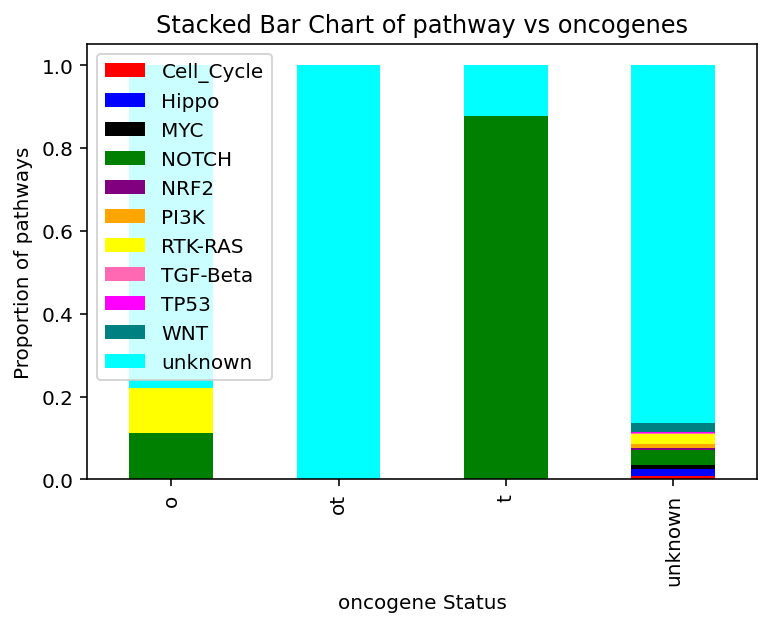

In [13]:
table        = pd.crosstab(common_de_new.types,common_de_new.Pathway)
color        = list('rgbkymc')
color_dict   = { 'Cell_Cycle':'red', 'Hippo':'blue', 'MYC':'black', 'NOTCH':'green','NRF2':'purple' ,
              'PI3K':'orange','RTK-RAS':'yellow','TGF-Beta':'hotpink','TP53':'magenta','WNT':'teal','unknown':'aqua'}
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,color=color_dict)
plt.legend(loc='upper left')
plt.title('Stacked Bar Chart of pathway vs oncogenes')
plt.xlabel('oncogene Status')
plt.ylabel('Proportion of pathways')
plt.savefig('pathway_vs_oncogene_stack')

Text(0, 0.5, 'Frequency of Purchase')

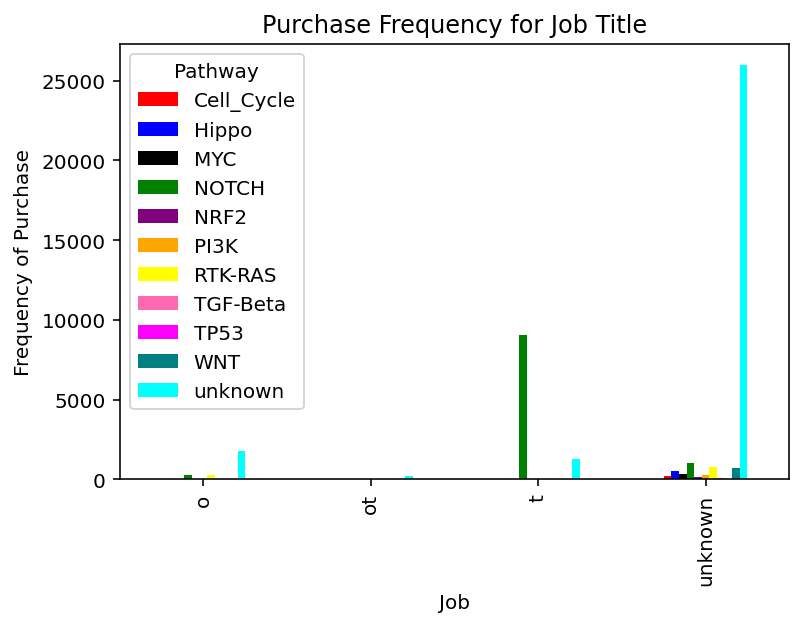

In [227]:
pd.crosstab(common_de_new.types,common_de_new.Pathway).plot(kind='bar',color=color_dict)
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
#plt.title('Purchase Frequency for Job Title')

Text(0, 0.5, 'Proportion of pathways')

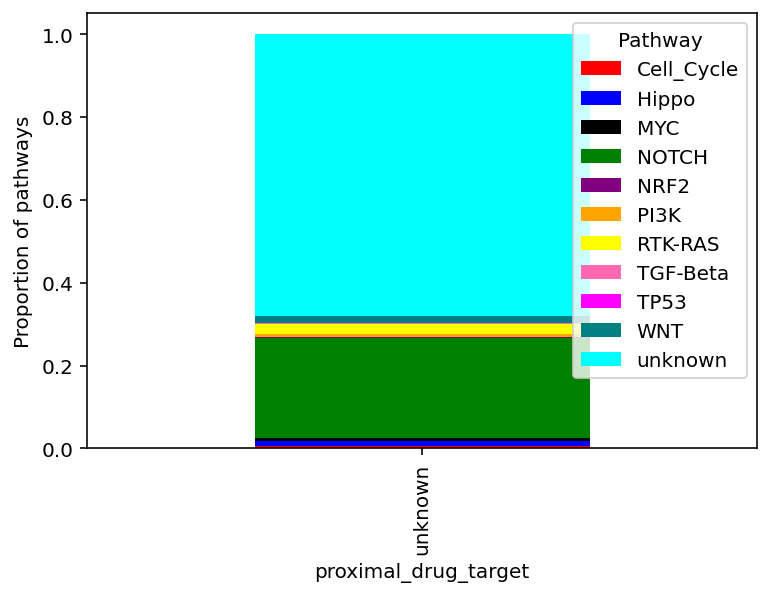

In [238]:
table=pd.crosstab(common_de_new.proximal_drug_target,common_de_new.Pathway)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,color=color_dict)
#plt.title('Stacked Bar Chart of Education vs Purchase')
#plt.xlabel('Education')
plt.ylabel('Proportion of pathways')
#plt.savefig('edu_vs_pur_stack')

In [14]:
common_de_new['sample'].drop_duplicates()

0      COAD
1      HNSC
2      KICH
3      LIHC
4      LUAD
5      LUSC
6      PRAD
7      STAD
8      THCA
9      BRCA
26     KIRC
38     KIRP
58     ESCA
356    PAAD
Name: sample, dtype: object

In [14]:
keep_samples =['BRCA','KICH','PRAD','STAD','KIRP']

In [416]:
BRCA =common_de_new.query('sample =="PAAD"')

In [22]:
common_de_new.shape

(42914, 16)

In [16]:
common_DE_5samples = common_de_new[common_de_new['sample'].isin(keep_samples)]

In [17]:
up_de_common   = common_DE_5samples.query('logFC>=0.58')
down_de_common = common_DE_5samples.query('logFC<=-0.58')

In [18]:
count_no_pathway   = len(down_de_common[down_de_common['pathway_y']==0])
count_pathway      = len(down_de_common[down_de_common['pathway_y']==1])
count_pathway

8372

In [19]:
percentage_calc(count_pathway,count_no_pathway,"pathway")

percentage of lncRNAs withoutpathway 39.55234657039711
percentage of lncRNAs withpathway 60.44765342960289


(None, None)

Runing the logistic regression model for up and down regulated lncRNAs seperately

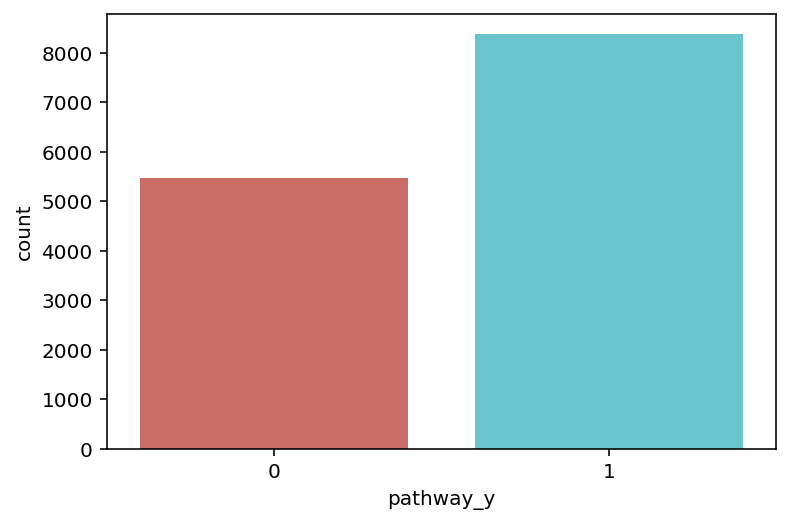

<Figure size 432x288 with 0 Axes>

In [20]:
sns.countplot(data = down_de_common,x='pathway_y',palette='hls')
plt.show()
plt.savefig("down_de_5samples_pathway.png")

In [186]:
pd.crosstab(down_de_common.sample,down_de_common.Pathway).plot(kind='bar',color=color_dict)
plt.title('Purchase Frequency for Job Title')
plt.xlabel('triplex')
plt.ylabel('Frequency of Pathway')
#plt.title('Purchase Frequency for Job Title')

TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

In [201]:
data =down_de_common

In [109]:
data.groupby('sample').mean()
#common_de_new.groupby('Pathway').mean()

,risk_alelle_freq,EZH2,H3K27,Meth_Mean,logFC,pathway_y
sample,,,,,,
BRCA,0.320000,1.561503,2.681120,0.692215,-1.787949,0.565063
KICH,0.433182,1.710165,2.750485,0.744119,-2.213485,0.557282
KIRP,0.461000,1.643565,2.749855,0.782672,-2.093471,0.596880
PRAD,0.410000,1.633132,2.758771,0.826321,-0.839813,0.666808
STAD,0.310000,1.619299,2.748294,0.769911,-0.858239,0.663493


In [99]:
count_no_pathway   = len(down_de_common[down_de_common['pathway_y']==0])
count_pathway      = len(down_de_common[down_de_common['pathway_y']==1])

percentage of lncRNAs withoutpathway for downde 58.073878627968334
percentage of lncRNAs withpathway for downde 41.92612137203166


In [151]:
data.columns.tolist()


['gene_sym',
 'proximal_cancer_driver',
 'proximal_drug_target',
 'triplex',
 'promoter_methylated',
 'negative_correlated_methylation',
 'positive_correlated_methylation',
 'sample',
 'risk_alelle_freq',
 'EZH2',
 'H3K27',
 'types',
 'Meth_Mean',
 'logFC',
 'Pathway',
 'pathway_y']

Choosing the columns which have categorical values to create a dummy dataframe 
The choosen columns/variables have only two values either yes or no.


In [202]:
cat_vars=['proximal_cancer_driver','negative_correlated_methylation','positive_correlated_methylation',
 'proximal_drug_target', 'promoter_methylated',
 'triplex',
 'sample',
 'types']
for var in cat_vars:
    cat_list = 'var '+'_'+ var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1    = data.join(cat_list)
    data     = data1
    
cat_vars     = ['proximal_cancer_driver','negative_correlated_methylation','positive_correlated_methylation',
 'proximal_drug_target', 'promoter_methylated',
 'triplex',
 'sample',
 'types']
data_vars    = data.columns.values.tolist()
to_keep      = [i for i in data_vars if i not in cat_vars]

In [153]:
cat_vars

['proximal_cancer_driver',
 'negative_correlated_methylation',
 'positive_correlated_methylation',
 'proximal_drug_target',
 'promoter_methylated',
 'triplex',
 'sample',
 'types']

In [203]:
data_final =data[to_keep]
data_final =data_final.replace(['o','t','ot'],1)

In [205]:
data_final.drop(['gene_sym','Pathway'],axis=1,inplace=True)


In [206]:
data_final=data_final.replace(['unknown', 'Yes'], 
                     [0,1])
data_final=data_final.fillna(0)

In [21]:
data_final.shape

NameError: name 'data_final' is not defined

In [208]:
! pip install imbalanced-learn -U

Creating a balanced sample by using Recurrssive feature elimination method

In [209]:
X  = data_final.loc[:, data_final.columns != 'pathway_y']
y  = data_final.loc[:, data_final.columns == 'pathway_y']
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns   = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y = pd.DataFrame(data=os_data_y,columns=['pathway_y'])

In [210]:
# Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no pathways in oversampled data",len(os_data_y[os_data_y['pathway_y']==0]))
print("Number of pathways",len(os_data_y[os_data_y['pathway_y']==1]))
print("Proportion of no pathways data in oversampled data is ",len(os_data_y[os_data_y['pathway_y']==0])/len(os_data_X))
print("Proportion of pathways data in oversampled data is ",len(os_data_y[os_data_y['pathway_y']==1])/len(os_data_X))

length of oversampled data is  11654
Number of no pathways in oversampled data 5827
Number of pathways 5827
Proportion of no pathways data in oversampled data is  0.5
Proportion of pathways data in oversampled data is  0.5


In [211]:
data_final_vars=data_final.columns.values.tolist()
data_final_vars

['risk_alelle_freq',
 'EZH2',
 'H3K27',
 'Meth_Mean',
 'logFC',
 'pathway_y',
 'proximal_cancer_driver_Yes',
 'proximal_cancer_driver_unknown',
 'negative_correlated_methylation_Yes',
 'negative_correlated_methylation_unknown',
 'positive_correlated_methylation_Yes',
 'positive_correlated_methylation_unknown',
 'proximal_drug_target_unknown',
 'promoter_methylated_Yes',
 'promoter_methylated_unknown',
 'triplex_Yes',
 'triplex_unknown',
 'sample_BRCA',
 'sample_KICH',
 'sample_KIRP',
 'sample_PRAD',
 'sample_STAD',
 'types_o',
 'types_ot',
 'types_t',
 'types_unknown']

In [212]:
y=['pathway_y']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[ True False False  True  True  True  True  True  True  True  True False
 False  True  True  True  True  True  True False  True  True  True  True
  True]
[1 2 4 1 1 1 1 1 1 1 1 3 5 1 1 1 1 1 1 6 1 1 1 1 1]


/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

In [213]:
os_data_X.columns.values.tolist()

['risk_alelle_freq',
 'EZH2',
 'H3K27',
 'Meth_Mean',
 'logFC',
 'proximal_cancer_driver_Yes',
 'proximal_cancer_driver_unknown',
 'negative_correlated_methylation_Yes',
 'negative_correlated_methylation_unknown',
 'positive_correlated_methylation_Yes',
 'positive_correlated_methylation_unknown',
 'proximal_drug_target_unknown',
 'promoter_methylated_Yes',
 'promoter_methylated_unknown',
 'triplex_Yes',
 'triplex_unknown',
 'sample_BRCA',
 'sample_KICH',
 'sample_KIRP',
 'sample_PRAD',
 'sample_STAD',
 'types_o',
 'types_ot',
 'types_t',
 'types_unknown']

In [77]:
os_data_y['pathway_y']

0        1
1        0
2        0
3        0
4        0
        ..
15957    1
15958    1
15959    1
15960    1
15961    1
Name: pathway_y, Length: 15962, dtype: int64

In [215]:
cols=['risk_alelle_freq',
 'Meth_Mean',
 'logFC',
 'positive_correlated_methylation_Yes',
 'promoter_methylated_unknown',
 'triplex_Yes',
 'triplex_unknown',
 'sample_BRCA',
 'sample_KICH',
 'sample_KIRP',
 'sample_STAD',
 'types_o',
 'types_t',
 'types_unknown']
X=os_data_X[cols]
y=os_data_y['pathway_y']

In [216]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.198791
         Iterations 8
                                  Results: Logit
Model:                     Logit                  Pseudo R-squared:       0.713    
Dependent Variable:        pathway_y              AIC:                    4661.4137
Date:                      2021-02-25 00:54       BIC:                    4764.5014
No. Observations:          11654                  Log-Likelihood:         -2316.7  
Df Model:                  13                     LL-Null:                -8077.9  
Df Residuals:              11640                  LLR p-value:            0.0000   
Converged:                 1.0000                 Scale:                  1.0000   
No. Iterations:            8.0000                                                  
-----------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------

In [171]:
pvals=[]
import statsmodels
p=statsmodels.stats.multitest.fdrcorrection(pvals , alpha=0.05, method='indep', is_sorted=False)
pd.DataFrame(p)

""
0
1


In [217]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(C=1.0,class_weight=None,dual=False, fit_intercept=True,intercept_scaling=1,
                   max_iter=100,multi_class='ovr',n_jobs=1, penalty='l2',random_state=None,solver='liblinear',tol=0.0001,
                  verbose=0,warm_start=False)
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [218]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.93


In [219]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1703   53]
 [ 184 1557]]


Accuracy:  0.9322276236774378


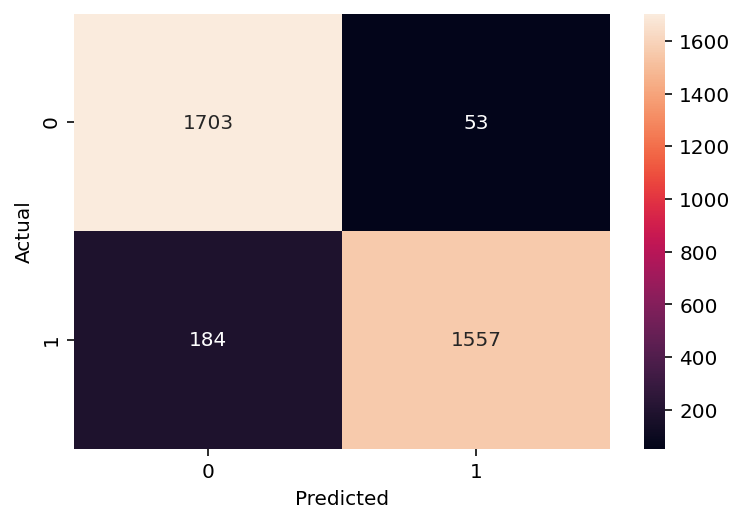

In [175]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='g')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.savefig('5samples_down_regulated.png')

plt.show()

In [220]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1756
           1       0.97      0.89      0.93      1741

    accuracy                           0.93      3497
   macro avg       0.93      0.93      0.93      3497
weighted avg       0.93      0.93      0.93      3497



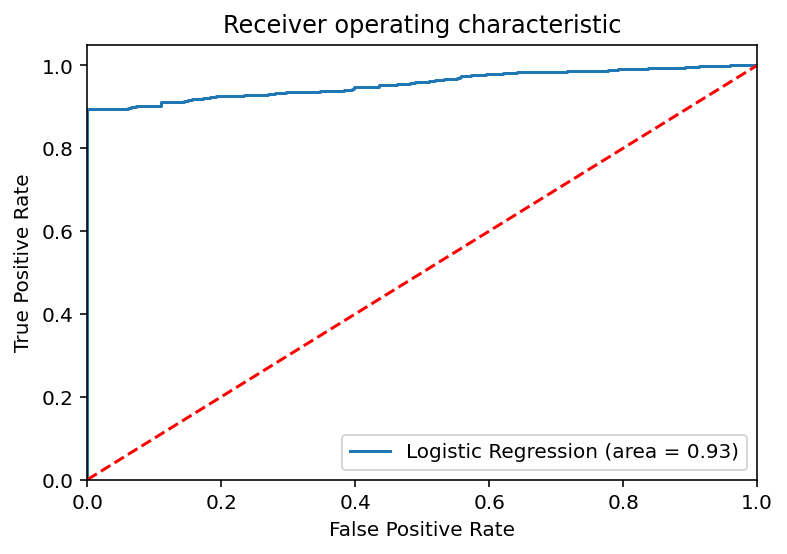

In [221]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_5samples_down_regulated_with_features.png')
plt.show()